In [5]:
"""Multi-criteria performance assessment based on closed-loop system identification
"""

from matplotlib.pyplot import * # Grab MATLAB plotting functions
import numpy as np
from scipy import signal

import sys
!{sys.executable} -m pip install control
!{sys.executable} -m pip install git+https://github.com/statsmodels/statsmodels
from control.matlab import *    # MATLAB-like functions
from control import *
from statsmodels.tsa.arima.model import ARIMA

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-73xra7v7
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-73xra7v7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [6]:
# Plant model
b1 = 1
b0 = 0

B = [b1,b0]

a1 = 1
a0 = -0.9
A  = [a1,a0]

c1 = 1
c0 = 0
C  = [c1,c0]


e0 = 1
e1 = 0

f1 = 0
f0 = c0 - a0

E = [e1,e0]

F = [f1,f0]

EB = [e0,e0*b0]

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
1 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from the model
3 states have been removed from the model
0 states have been removed from the model
2 states have been removed from th

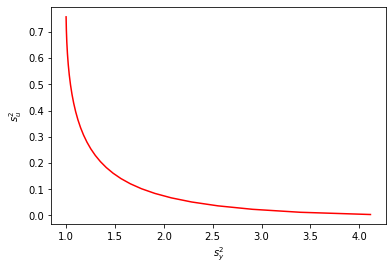

In [7]:
# Pareto front approximation, based on actual model
final_p = 10000
sampling_t = 1
t = np.arange(0.0, final_p, sampling_t)
Ft = len(t)

G1 = minreal(tf(B, A,sampling_t))
G2 = minreal(tf(C, A,sampling_t))
Gy = minreal(tf(F, C,sampling_t))
Gu = minreal(tf(EB, C,sampling_t))
T1 = np.arange(0.0, 300, sampling_t)
NPar = 30 #Pareto approximation size
Par = np.zeros((NPar-1,2))
for k in range(1,NPar):
    alpha = k/NPar 
    Gc = minreal((alpha*Gy*Gu/(1-alpha+alpha*Gu*Gu)))

    Gycl = minreal(G2/(1+G1*Gc))
    Gucl = minreal(G2*Gc/(1+G1*Gc))

    T1, y1 = impulse_response(Gucl,T1)
    T1, y2 = impulse_response(Gycl,T1)
    Par[k-1,0] = np.dot(y1,y1.T) 
    Par[k-1,1] = np.dot(y2,y2.T)
        
figure(1)
xlabel('$s_{y}^{2}$')
ylabel('$s_{u}^{2}$')
plot(Par[:,1],Par[:,0],'r')

In [8]:
# Pareto front approximation, based on identified model
Gp = minreal(tf(B, A,sampling_t))
Gc = tf([0.0, 0.2],[1, -0.8999],sampling_t)
Gycl = minreal(Gp/(1+Gp*Gc))
Gucl = minreal(Gp*Gc/(1+Gp*Gc))

final_p = 10000
t = np.arange(0.0, final_p, sampling_t)
Ft = len(t)
var_hok = 0
var_lok = 0
np.random.seed(0)
while var_hok == 0 or var_hok == 0 :
    epsilon = np.random.normal(0,1,size = (Ft,1))
    var_eps = np.var(epsilon)
    if var_eps > 1.1:
        epsilon = 0.99*epsilon
    else:    
        var_hok = 1
        
    if var_eps < 0.9:
        epsilon = 1.01*epsilon
    else:    
        var_lok = 1

ysim, tout, x = lsim(Gycl, epsilon.T, t)
usim, tout, x = lsim(Gucl, epsilon.T, t)
arma_mod = ARIMA(ysim, order=(3, 0, 3))
arma_res = arma_mod.fit()
print(arma_res.summary())

Gcle = tf(arma_res.polynomial_ma,arma_res.polynomial_ar,sampling_t)

Gpe = minreal(Gcle/(1-Gcle*Gc))

Be = Gpe.num[0][0]
Ae = Gpe.den[0][0]

#From Diophantine equation
E = [1.0000]

F = [ Be[1] - Ae[1] , Be[2] - Ae[2] , Be[3] - Ae[3], Be[4] - Ae[4]]

EB = np.polymul(E,Be)
FE = np.polymul(F,E)
G1 = minreal(tf(Be, FE,sampling_t))
G2 = minreal(tf(EB, F,sampling_t))

T1 = np.arange(0.0, 300, sampling_t)
NPar = 30 #Pareto approximation size
Par = np.zeros((NPar-1,2))
for k in range(1,NPar):
    alpha = k/NPar 
    Gc = minreal(alpha/((1-alpha)*G1+alpha*G2))
    Gycl = minreal(Gpe/(1+Gpe*Gc))
    Gucl = minreal(Gpe*Gc/(1+Gpe*Gc))
    T1, y1 = impulse_response(Gucl,T1)
    T1, y2 = impulse_response(Gycl,T1)
    Par[k-1,0] = np.dot(y1,y1.T)  
    Par[k-1,1] = np.dot(y2,y2.T)

0 states have been removed from the model
1 states have been removed from the model
2 states have been removed from the model


/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(3, 0, 3)   Log Likelihood              -14057.942
Date:                Fri, 15 Oct 2021   AIC                          28131.885
Time:                        07:45:19   BIC                          28189.568
Sample:                             0   HQIC                         28151.410
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0.004     -2.058      0.040      -0.018      -0.000
ar.L1          1.4943      0.442      3.381      0.001       0.628       2.360
ar.L2         -0.6541      0.706     -0.926      0.3

0 states have been removed from the model
1 states have been removed from the model
2 states have been removed from the model
etamv =  36.484606626793
etamv =  44.386484598995516


/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


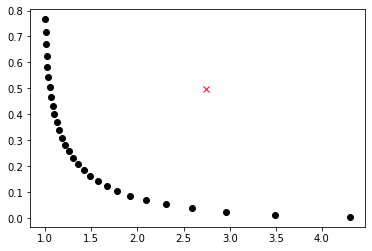

In [10]:
#Generating test data 
Gp = minreal(tf(B, A,sampling_t))
Gc = tf([0.0, 0.2],[1, -0.8999],sampling_t)
Gycl = minreal(Gp/(1+Gp*Gc))
Gucl = minreal(Gp*Gc/(1+Gp*Gc))  
final_p = 1000
t = np.arange(0.0, final_p, sampling_t)
Ft = len(t)
var_hok = 0
var_lok = 0
np.random.seed(0)
while var_hok == 0 or var_hok == 0 :
    epsilon = np.random.normal(0,1,size = (Ft,1))
    var_eps = np.var(epsilon)
    if var_eps > 1.1:
        epsilon = 0.99*epsilon
    else:    
        var_hok = 1
        
    if var_eps < 0.9:
        epsilon = 1.01*epsilon
    else:    
        var_lok = 1

ysim, tout, x = lsim(Gycl, epsilon.T, t)
usim, tout, x = lsim(Gucl, epsilon.T, t)

#Finding nearest point in Pareto front
s1 = np.var(usim,ddof=1)
s2 = np.var(ysim,ddof=1)
min_dist = 1e20
min_index = round(NPar/2)
for k in range(1,NPar):     
    s1P = Par[k-1,1] 
    s2P = Par[k-1,0]
    if s1P < s1 and s2P < s2:
        dist = np.sqrt((s1P  - s1)**2 + (s2P - s2)**2)
        if dist < min_dist:
            min_dist = dist
            min_index = k-1
figure(1)
plot(Par[:,1],Par[:,0],'ok')
plot(s2,s1,'xr')

etamv = 100/s2
etay = 100*Par[min_index,1]/s2

print("etamv = ",etamv)
print("etamv = ",etay)